<a href="https://colab.research.google.com/github/soliman787/Soft-Computing/blob/main/Copy_of_Soft_Project_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_raw = pd.read_csv('/content/crimedata.csv')

df_raw.head()

,communityName,state,countyCode,communityCode,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,11980,3.10,1.37,91.78,6.50,1.88,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,23123,2.82,0.80,95.57,3.44,0.85,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,29344,2.43,0.74,94.33,3.43,2.35,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,16656,2.40,1.70,97.35,0.50,0.70,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,11245,2.76,0.53,89.16,1.17,0.52,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [ ]:
df_raw.info()
df_raw.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 146 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(28), object(2)
memory usage: 2.5+ MB


,0
communityName,object
state,object
countyCode,float64
communityCode,float64
population,int64
...,...
autoTheftPerPop,float64
arsons,float64
arsonsPerPop,float64
ViolentCrimesPerPop,float64


In [ ]:
!pip install deap
!pip install pyswarms

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from deap import base, creator, tools, algorithms

import pyswarms as ps

import matplotlib.pyplot as plt
import seaborn as sns
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Data Preprocessing
print("\n--- Data Preprocessing ---")


if 'ViolentCrimesPerPop' not in df_raw.columns:
    print("ERROR: 'ViolentCrimesPerPop' column not found. Please check column names.")

    if df_raw.shape[1] > 5:
        target_col_name = df_raw.columns[-1]
        print(f"Assuming '{target_col_name}' is the target variable based on position.")
        if df_raw[target_col_name].isnull().all():
             print(f"Target column {target_col_name} is all NaNs. Cannot proceed with it as target.")

             numeric_cols_for_target = df_raw.select_dtypes(include=np.number).columns
             if len(numeric_cols_for_target) > 0:
                 target_col_name = numeric_cols_for_target[0] # Take the first numeric one
                 print(f"WARNING: Using '{target_col_name}' as a fallback target. THIS IS LIKELY WRONG. Please verify.")
             else:
                 print("FATAL: No suitable numeric target column found. Please inspect your data.")
                 exit()
    else:
        print("FATAL: Cannot automatically determine target. Please inspect data.")
        exit()
else:
    target_col_name = 'ViolentCrimesPerPop'

df_raw.dropna(subset=[target_col_name], inplace=True)
print(f"Shape after dropping rows with missing target ({target_col_name}): {df_raw.shape}")

if df_raw.empty:
    print(f"FATAL: No data left after dropping NaNs in target column '{target_col_name}'. Check data quality.")
    exit()

median_crime = df_raw[target_col_name].median()
df_raw['crime_category'] = (df_raw[target_col_name] > median_crime).astype(int)
y = df_raw['crime_category']


--- Data Preprocessing ---
Shape after dropping rows with missing target (ViolentCrimesPerPop): (1994, 146)


In [ ]:
# Data Preprocessing
print("\n--- Data Preprocessing ---")


if 'ViolentCrimesPerPop' not in df_raw.columns:
    print("ERROR: 'ViolentCrimesPerPop' column not found. Please check column names.")

    if df_raw.shape[1] > 5:
        target_col_name = df_raw.columns[-1]
        print(f"Assuming '{target_col_name}' is the target variable based on position.")
        if df_raw[target_col_name].isnull().all():
             print(f"Target column {target_col_name} is all NaNs. Cannot proceed with it as target.")

             numeric_cols_for_target = df_raw.select_dtypes(include=np.number).columns
             if len(numeric_cols_for_target) > 0:
                 target_col_name = numeric_cols_for_target[0] # Take the first numeric one
                 print(f"WARNING: Using '{target_col_name}' as a fallback target. THIS IS LIKELY WRONG. Please verify.")
             else:
                 print("FATAL: No suitable numeric target column found. Please inspect your data.")
                 exit()
    else:
        print("FATAL: Cannot automatically determine target. Please inspect data.")
        exit()
else:
    target_col_name = 'ViolentCrimesPerPop'

df_raw.dropna(subset=[target_col_name], inplace=True)
print(f"Shape after dropping rows with missing target ({target_col_name}): {df_raw.shape}")

if df_raw.empty:
    print(f"FATAL: No data left after dropping NaNs in target column '{target_col_name}'. Check data quality.")
    exit()

median_crime = df_raw[target_col_name].median()
df_raw['crime_category'] = (df_raw[target_col_name] > median_crime).astype(int)
y = df_raw['crime_category']


--- Data Preprocessing ---
Shape after dropping rows with missing target (ViolentCrimesPerPop): (1994, 147)


In [ ]:
# 2. Select features (X) - drop original target, new categorical target, and non-predictive columns

cols_to_drop = [target_col_name, 'crime_category', 'communityname', 'state', 'county', 'community', 'fold']
cols_to_drop_existing = [col for col in cols_to_drop if col in df_raw.columns]
X = df_raw.drop(columns=cols_to_drop_existing)
print(f"Features selected. Shape of X: {X.shape}")

Features selected. Shape of X: (1994, 144)


In [ ]:
# 3. Handle missing values in features (X) using median imputation
for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
        except ValueError:
            print(f"Could not convert column {col} to numeric. It might contain non-numeric strings other than '?'. Dropping it.")
            X.drop(columns=[col], inplace=True)

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

print("Missing values handled. Shape of X after imputation:", X.shape)
if X.empty or X.shape[1] == 0:
    print("FATAL: No features remaining after preprocessing. Check data and column drop logic.")
    exit()

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for feature selection steps
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


print(f"Data split and scaled. X_train shape: {X_train_scaled_df.shape}, X_test shape: {X_test_scaled_df.shape}")

# Store results
results = {}

Could not convert column communityName to numeric. It might contain non-numeric strings other than '?'. Dropping it.
Missing values handled. Shape of X after imputation: (1994, 143)
Data split and scaled. X_train shape: (1395, 143), X_test shape: (599, 143)


In [ ]:
# Helper function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    # print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# Scenario 1 - Using original dataset with all available features

print("\n--- Scenario 1: Model with All Features ---")
# MODIFIED: Changed to LogisticRegression
model_all_features = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000) # Increased max_iter for potential convergence issues
model_all_features.fit(X_train_scaled_df, y_train)
y_pred_all = model_all_features.predict(X_test_scaled_df)
results['All Features'] = evaluate_model(y_test, y_pred_all, "Logistic Regression (All Features)")

# Identify most influential features from the full model
# MODIFIED: For Logistic Regression, we look at coefficients
if hasattr(model_all_features, 'coef_'):
    importances_all = np.abs(model_all_features.coef_[0]) # Absolute values of coefficients for magnitude
    feature_names_all = X.columns
    feature_importance_df_all = pd.DataFrame({'feature': feature_names_all, 'importance': importances_all})
    feature_importance_df_all = feature_importance_df_all.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (All Features Model - based on coefficient magnitude):")
    print(feature_importance_df_all.head(10))
else:
    print("Could not retrieve feature importances (coefficients) for the 'All Features' model.")


--- Scenario 1: Model with All Features ---

--- Logistic Regression (All Features) ---
Accuracy: 0.9516
Precision: 0.9518
Recall: 0.9516
F1-Score: 0.9516

Top 10 features (All Features Model - based on coefficient magnitude):
              feature  importance
133     assaultPerPop    8.228673
131       robbbPerPop    3.351383
129       rapesPerPop    0.852288
23        whitePerCap    0.839561
31    PctLess9thGrade    0.763414
30     PctPopUnderPov    0.598893
57      PctImmigRec10    0.578409
66   PersPerOccupHous    0.516306
132          assaults    0.500687
46        PctKids2Par    0.493173


In [ ]:
print("\n--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---")

# GA Parameters
N_POPULATION = 30
N_GENERATIONS = 20
CXPB = 0.6
MUTPB = 0.2
N_FEATURES = X_train_scaled_df.shape[1]

# Define Fitness: We want to maximize F1-score
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


--- Scenario 2: Feature Selection with Genetic Algorithm (GA) ---


In [ ]:
# Evaluation function for GA
def evalFeatures(individual):
    selected_feature_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected_feature_indices: #
        return 0,

    # Select features based on the individual
    X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
    X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]

    model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500, solver='liblinear')
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    return f1_score(y_test, y_pred, average='weighted', zero_division=0),

toolbox.register("evaluate", evalFeatures)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# Run GA
print(f"Running GA with {N_POPULATION} individuals for {N_GENERATIONS} generations...")
population = toolbox.population(n=N_POPULATION)
# To track best fitness over generations
logbook = tools.Logbook()
logbook.header = "gen", "evals", "avg", "min", "max"
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)


for gen in range(N_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(offspring), **record)
    print(logbook.stream)


best_individual_ga = tools.selBest(population, k=1)[0]
selected_features_ga_indices = [i for i, bit in enumerate(best_individual_ga) if bit == 1]

if not selected_features_ga_indices:
    print("GA selected no features. This can happen. Using all features as a fallback for this scenario.")
    X_train_ga_selected = X_train_scaled_df
    X_test_ga_selected = X_test_scaled_df
    selected_feature_names_ga = X.columns.tolist()
else:
    selected_feature_names_ga = X.columns[selected_features_ga_indices].tolist()
    X_train_ga_selected = X_train_scaled_df.iloc[:, selected_features_ga_indices]
    X_test_ga_selected = X_test_scaled_df.iloc[:, selected_features_ga_indices]

print(f"\nGA selected {len(selected_feature_names_ga)} features: {selected_feature_names_ga[:10]}...") # Print first 10

Running GA with 30 individuals for 20 generations...
gen	evals	avg     	min     	max     
0  	30   	0.925892	0.856318	0.973286
1  	30   	0.96254 	0.941548	0.973281
2  	30   	0.96783 	0.949906	0.973281
3  	30   	0.969668	0.964929	0.971615
4  	30   	0.970447	0.966601	0.973286
5  	30   	0.971227	0.966609	0.973286
6  	30   	0.972339	0.969944	0.978296
7  	30   	0.972506	0.969946	0.973286
8  	30   	0.97323 	0.971615	0.974956
9  	30   	0.973843	0.973286	0.974956
10 	30   	0.974566	0.973286	0.976625
11 	30   	0.975512	0.973286	0.978294
12 	30   	0.976625	0.974956	0.978294
13 	30   	0.977404	0.973286	0.978294
14 	30   	0.97796 	0.976625	0.978294
15 	30   	0.978238	0.976625	0.978294
16 	30   	0.978294	0.978294	0.978294
17 	30   	0.978127	0.973281	0.978294
18 	30   	0.978182	0.974952	0.978294
19 	30   	0.978182	0.974954	0.978294

GA selected 66 features: ['racepctblack', 'racePctHisp', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'medIncome', 'whitePerCap', 'blackPerCap', 'OtherPerCap

In [ ]:
# Train final model with GA selected features

model_ga = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_ga.fit(X_train_ga_selected, y_train)
y_pred_ga = model_ga.predict(X_test_ga_selected)
results['GA Selected'] = evaluate_model(y_test, y_pred_ga, "Logistic Regression (GA Selected Features)")


if len(selected_feature_names_ga) > 0 and not X_train_ga_selected.empty and hasattr(model_ga, 'coef_') :
    importances_ga = np.abs(model_ga.coef_[0])
    feature_importance_df_ga = pd.DataFrame({'feature': selected_feature_names_ga, 'importance': importances_ga})
    feature_importance_df_ga = feature_importance_df_ga.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (GA Selected Model - based on coefficient magnitude):")
    print(feature_importance_df_ga.head(10))
else:
    print("No features selected by GA, features dataframe is empty, or could not retrieve coefficients, skipping importance.")

if "FitnessMax" in dir(creator):
    del creator.FitnessMax
if "Individual" in dir(creator):
    del creator.Individual


--- Logistic Regression (GA Selected Features) ---
Accuracy: 0.9766
Precision: 0.9768
Recall: 0.9766
F1-Score: 0.9766

Top 10 features (GA Selected Model - based on coefficient magnitude):
             feature  importance
59     assaultPerPop    8.480988
57       robbbPerPop    3.727144
56       rapesPerPop    0.833838
65     nonViolPerPop    0.792134
7        whitePerCap    0.584400
58          assaults    0.556310
20          NumImmig    0.516749
23     PctImmigRec10    0.487112
5          numbUrban    0.433784
27  PersPerOccupHous    0.418106


In [ ]:
print("\n--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---")

# PSO Parameters
N_PARTICLES = 30
N_ITERATIONS = 20

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': N_PARTICLES // 2, 'p': 2}

def pso_fitness_func(swarm_particle_matrix):
    costs = []
    for particle_idx in range(swarm_particle_matrix.shape[0]):
        particle = swarm_particle_matrix[particle_idx, :]
        selected_feature_indices = np.where(particle == 1)[0]

        if len(selected_feature_indices) == 0:
            costs.append(1.0)
            continue

        X_train_subset = X_train_scaled_df.iloc[:, selected_feature_indices]
        X_test_subset = X_test_scaled_df.iloc[:, selected_feature_indices]

        model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500, solver='liblinear')
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        costs.append(1.0 - f1)
    return np.array(costs)


--- Scenario 3: Feature Selection with Particle Swarm Optimization (PSO) ---


In [ ]:
optimizer = ps.discrete.BinaryPSO(n_particles=N_PARTICLES, dimensions=N_FEATURES, options=options)

# Perform optimization
print(f"Running PSO with {N_PARTICLES} particles for {N_ITERATIONS} iterations...")
cost, best_pos_pso = optimizer.optimize(pso_fitness_func, iters=N_ITERATIONS, verbose=True)

selected_features_pso_indices = np.where(best_pos_pso == 1)[0]

if len(selected_features_pso_indices) == 0:
    print("PSO selected no features. Using all features as a fallback.")
    X_train_pso_selected = X_train_scaled_df
    X_test_pso_selected = X_test_scaled_df
    selected_feature_names_pso = X.columns.tolist()
else:
    selected_feature_names_pso = X.columns[selected_features_pso_indices].tolist()
    X_train_pso_selected = X_train_scaled_df.iloc[:, selected_features_pso_indices]
    X_test_pso_selected = X_test_scaled_df.iloc[:, selected_features_pso_indices]

print(f"\nPSO selected {len(selected_feature_names_pso)} features: {selected_feature_names_pso[:10]}...")

model_pso = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_pso.fit(X_train_pso_selected, y_train)
y_pred_pso = model_pso.predict(X_test_pso_selected)
results['PSO Selected'] = evaluate_model(y_test, y_pred_pso, "Logistic Regression (PSO Selected Features)")


if len(selected_feature_names_pso) > 0 and not X_train_pso_selected.empty and hasattr(model_pso, 'coef_'):
    importances_pso = np.abs(model_pso.coef_[0])
    feature_importance_df_pso = pd.DataFrame({'feature': selected_feature_names_pso, 'importance': importances_pso})
    feature_importance_df_pso = feature_importance_df_pso.sort_values(by='importance', ascending=False)
    print("\nTop 10 features (PSO Selected Model - based on coefficient magnitude):")
    print(feature_importance_df_pso.head(10))
else:
    print("No features selected by PSO, features dataframe is empty, or could not retrieve coefficients, skipping importance.")

2025-05-15 23:25:02,921 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 15, 'p': 2}


Running PSO with 30 particles for 20 iterations...


pyswarms.discrete.binary: 100%|██████████|20/20, best_cost=0.0217
2025-05-15 23:25:38,861 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.021706225946293345, best pos: [1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0
 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0
 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0
 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0]



PSO selected 79 features: ['countyCode', 'communityCode', 'population', 'racepctblack', 'racePctAsian', 'racePctHisp', 'agePct16t24', 'agePct65up', 'pctUrban', 'medIncome']...

--- Logistic Regression (PSO Selected Features) ---
Accuracy: 0.9783
Precision: 0.9786
Recall: 0.9783
F1-Score: 0.9783

Top 10 features (PSO Selected Model - based on coefficient magnitude):
             feature  importance
77     assaultPerPop    8.405563
75       robbbPerPop    4.068743
73       rapesPerPop    0.834982
15       whitePerCap    0.833348
33     PctImmigRec10    0.593458
39  PersPerOccupHous    0.576119
76          assaults    0.525409
29          NumImmig    0.480642
11        pctWInvInc    0.388063
35      PctRecImmig5    0.355091



--- Performance Summary ---
              accuracy  precision    recall        f1
All Features  0.951586   0.951831  0.951586  0.951578
GA Selected   0.976628   0.976818  0.976628  0.976625
PSO Selected  0.978297   0.978558  0.978297  0.978294


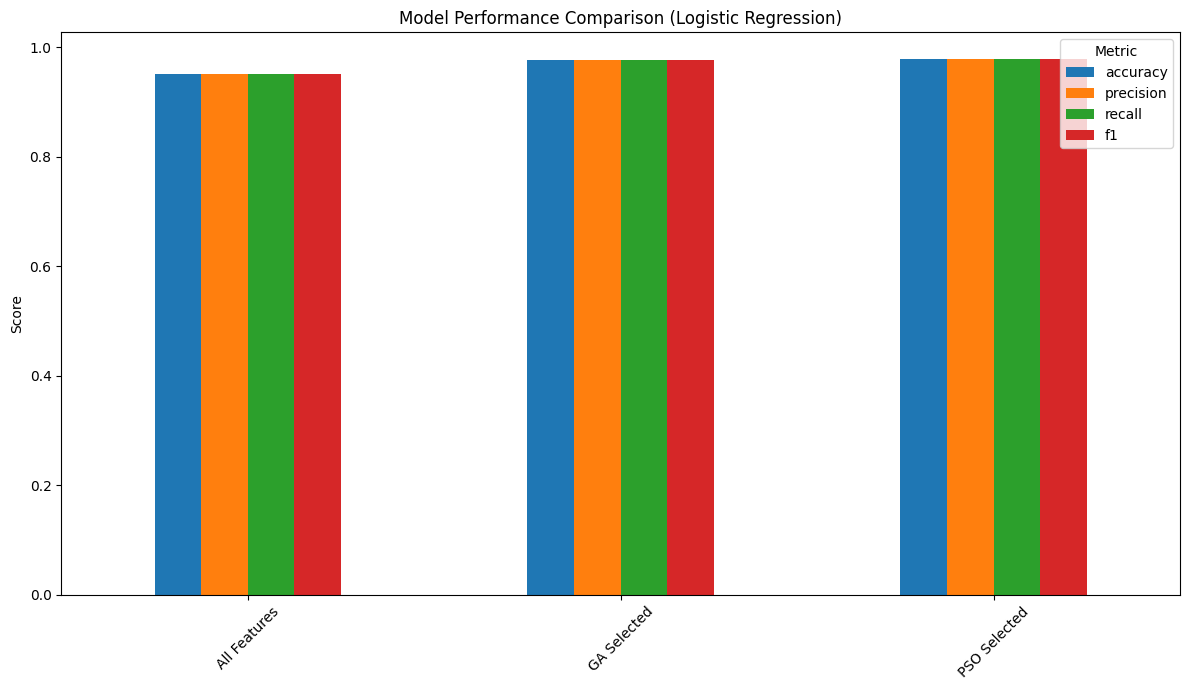

In [ ]:
# Summarize and Compare Performance

print("\n--- Performance Summary ---")
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1']]

print(results_df)

# Bar chart for comparison
results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison (Logistic Regression)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()

plt.savefig('performance_comparison_chart_logistic_regression.png')
plt.show()

In [ ]:
print("\n--- Project Documentation Placeholders ---")
# MODIFIED: Updated for Logistic Regression
print("\n1. ML Algorithm (Logistic Regression):")
print("   - Flowchart: [Conceptual: Data (Features X, Target y)] -> [Initialize Weights (w) and Bias (b)] -> ")
print("                [For each epoch OR until convergence: ")
print("                  [Calculate Linear Combination (z = wX + b)] -> ")
print("                  [Apply Sigmoid Function (p = 1 / (1 + exp(-z)))] -> ")
print("                  [Calculate Loss (e.g., Log Loss/Cross-Entropy)] -> ")
print("                  [Calculate Gradients of Loss w.r.t. w and b] -> ")
print("                  [Update Weights and Bias using Gradient Descent (w = w - lr*grad_w, b = b - lr*grad_b)] ")
print("                ] -> [Trained Model (Optimized w, b)] -> [Prediction on New Data]")
print("   - Pseudocode:")
print("     Algorithm LogisticRegressionTrain(TrainingSet D(X,y), LearningRate lr, Epochs E):")
print("       Initialize weights w (vector), bias b (scalar) (e.g., to zeros or small random values)")
print("       For epoch = 1 to E:")
print("         For each training example (x_i, y_i) in D (or use batch/mini-batch):")
print("           z_i = dot_product(w, x_i) + b")
print("           p_i = sigmoid(z_i)  // sigmoid(z) = 1 / (1 + exp(-z))")
print("           // Calculate gradient for log loss: L = -[y_i * log(p_i) + (1 - y_i) * log(1 - p_i)]")
print("           gradient_wrt_z = p_i - y_i") # Gradient of log loss w.r.t z
print("           gradient_w = gradient_wrt_z * x_i")
print("           gradient_b = gradient_wrt_z")
print("           // Update weights and bias")
print("           w = w - lr * gradient_w")
print("           b = b - lr * gradient_b")
print("       Return w, b")
print("")
print("     To predict for instance x_new with trained w, b:")
print("       z_new = dot_product(w, x_new) + b")
print("       p_new = sigmoid(z_new)")
print("       Return 1 if p_new >= 0.5 else 0 (for binary classification)")


print("\n2. GA Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Population -> Evaluate Fitness -> Selection -> Crossover -> Mutation -> New Population -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm GeneticAlgorithmFeatureSelection(Features, Target, PopSize, Generations):")
print("       Initialize Population P with random binary strings (individuals, representing feature subsets)")
print("       For g = 1 to Generations:")
print("         For each individual I in P:")
print("           Fitness(I) = EvaluateMLModel(Features_selected_by_I, Target) // e.g., F1-score of Logistic Regression")
print("         P_selected = SelectParents(P, Fitness_values) // e.g., Tournament, Roulette Wheel")
print("         P_offspring = Crossover(P_selected) // e.g., One-point, Two-point")
print("         P_mutated = Mutate(P_offspring) // e.g., Bit-flip")
print("         P = P_mutated (or combine with P_selected for elitism)")
print("       Return BestIndividual(P) // Individual with highest fitness")

print("\n3. PSO Optimization Algorithm Process:")
print("   - Flowchart: [Conceptual: Initialize Particles (positions, velocities) -> Evaluate Fitness -> Update Personal Best & Global Best -> Update Velocities -> Update Positions -> Repeat until termination]")
print("   - Pseudocode (for feature selection):")
print("     Algorithm PSOFeatureSelection(Features, Target, NumParticles, Iterations):")
print("       Initialize Particles (random binary positions for feature subsets, random velocities)")
print("       Initialize pBest_positions = current_positions, pBest_fitness = fitness of current_positions")
print("       Initialize gBest_position = best_among_pBests, gBest_fitness = best_among_pBest_fitness")
print("       For iter = 1 to Iterations:")
print("         For each particle i:")
print("           CurrentFitness_i = EvaluateMLModel(Features_selected_by_particle_i_position, Target) // e.g., F1-score of Logistic Regression")
print("           If CurrentFitness_i is better than pBest_fitness_i:")
print("             pBest_position_i = particle_i_position")
print("             pBest_fitness_i = CurrentFitness_i")
print("           If CurrentFitness_i is better than gBest_fitness:")
print("             gBest_position = particle_i_position")
print("             gBest_fitness = CurrentFitness_i")
print("         For each particle i:")
print("           Update_velocity(particle_i, pBest_position_i, gBest_position, inertia_w, c1, c2)")
print("           Update_position(particle_i) // Apply sigmoid to velocity for binary position update, ensure binary {0,1}")
print("       Return gBest_position")



print("\n5. Block diagram of the implemented system:")
# MODIFIED: Updated for Logistic Regression
print("   [Raw CSV Data] -> [Preprocessing (Handle Missing Values, Impute NaNs, Create Target Variable 'crime_category', Scale Features)] -> ")
print("     |--> [Scenario 1: Train Logistic Regression with All Scaled Features] --> [Evaluate Model 1 (Metrics: Acc, Prec, Rec, F1)]")
print("     |--> [Scenario 2: GA for Feature Selection on Scaled Features] -> [Identify GA-Selected Features] -> [Train Logistic Regression with GA-Selected Scaled Features] --> [Evaluate Model 2 (Metrics)]")
print("     |--> [Scenario 3: PSO for Feature Selection on Scaled Features] -> [Identify PSO-Selected Features] -> [Train Logistic Regression with PSO-Selected Scaled Features] --> [Evaluate Model 3 (Metrics)]")
print("     --> [Compare Metrics & Visualize Performance (Bar Chart)]")


--- Project Documentation Placeholders ---

1. ML Algorithm (Logistic Regression):
   - Flowchart: [Conceptual: Data (Features X, Target y)] -> [Initialize Weights (w) and Bias (b)] -> 
                [For each epoch OR until convergence: 
                  [Calculate Linear Combination (z = wX + b)] -> 
                  [Apply Sigmoid Function (p = 1 / (1 + exp(-z)))] -> 
                  [Calculate Loss (e.g., Log Loss/Cross-Entropy)] -> 
                  [Calculate Gradients of Loss w.r.t. w and b] -> 
                  [Update Weights and Bias using Gradient Descent (w = w - lr*grad_w, b = b - lr*grad_b)] 
                ] -> [Trained Model (Optimized w, b)] -> [Prediction on New Data]
   - Pseudocode:
     Algorithm LogisticRegressionTrain(TrainingSet D(X,y), LearningRate lr, Epochs E):
       Initialize weights w (vector), bias b (scalar) (e.g., to zeros or small random values)
       For epoch = 1 to E:
         For each training example (x_i, y_i) in D (or use batch/mini-